<a href="https://colab.research.google.com/github/Iamdohyun/AI_EXPLORATION/blob/main/EX_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **14. 인공지능으로 세상에 없던 새로운 패션 만들기**

****

## **0. INTRO**

저는 고등학교 내내 패션 공부를 한 적이 있습니다.  
그때 당시에 늘 학교가 끝나면 패션을 공부하러 갔고 패션쇼가 열리는 주간에는 매일 밤을 새우며 디자인을 수정했던 기억이 새록새록 납니다.  
그렇게 한때 열심히 공부하고 매달렸던 패션을 이번 익스를 통해 인공지능에 접목시킬 생각을 해보니 감회가 새롭고 벌써부터 웅장이 가슴 해집니다.  
  
    
들어가기 앞서 이번 익스를 잠깐 소개하고 가겠습니다.  
이번 익스는 기존에 많이 공부했던 판별 모델링이 아닌 생성 모델링입니다.  
생성 모델링은 학습한 데이터와 비슷하면서도 기존에는 없던 새로운 데이터셋을 생성하는 모델입니다.  
그럼 지금부터 익스를 구경하러 가겟습니다.  
같이 가시죠 :)

## **1. IMPORT**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os 
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers.convolutional import UpSampling2D, Conv2D
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

print('tensorflow', tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
tensorflow 2.8.2


늘 그렇듯 이제는 당연시 해야할 IMPORT입니다.

## **2. 데이터 셋 구성**

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [ ]:
print('Max pixel:', train_x.max())
print('Min pixel:', train_x.min())

Max pixel: 255
Min pixel: 0


In [ ]:
# 이미지를 [-1, 1] 로 정규화하기 위한 작업
train_x = (train_x - 127.5) / 127.5 

print('Max pixel:', train_x.max())
print('Min pixel:', train_x.min())

Max pixel: 1.0
Min pixel: -1.0


In [ ]:
train_x.shape

(50000, 32, 32, 3)

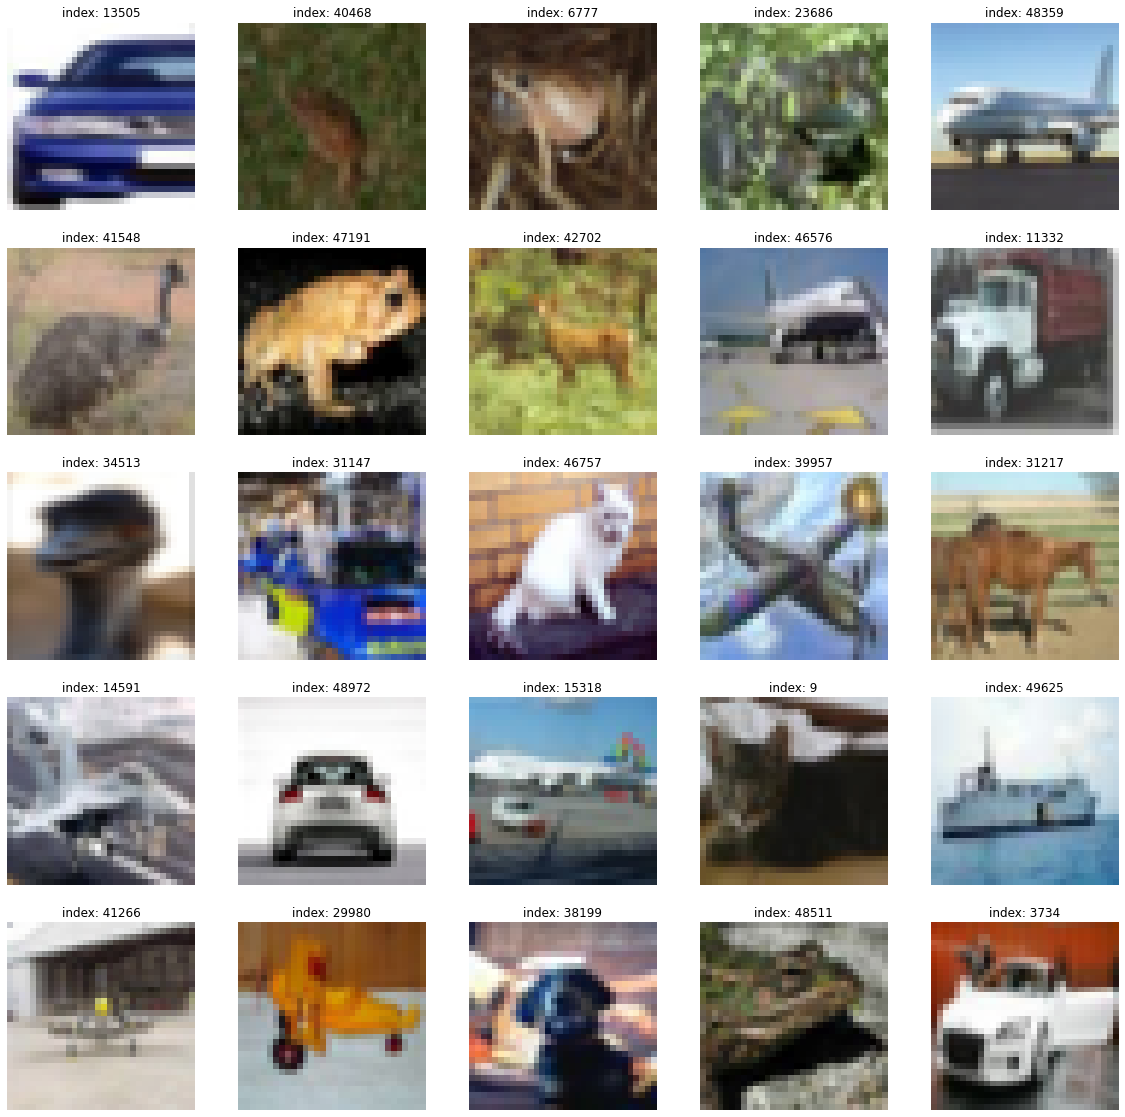

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index] + 1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

## **3. 생성 모델 구현**

In [ ]:
def make_generator_model_one():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [ ]:
generator_one = make_generator_model_one()

generator_one.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [ ]:
# 노이즈를 생성합니다.
noise = tf.random.normal([10, 100])
generated_image = generator_one(noise, training=False)
generated_image.shape

TensorShape([10, 32, 32, 3])

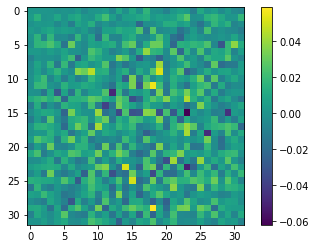

In [ ]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## **4. 판별 모델 구현**

In [ ]:
def make_discriminator_model_one():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model

In [ ]:
discriminator_one = make_discriminator_model_one()

discriminator_one.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

## **5. 손실함수 구현**

GAN 은 손실함수로 우리가 밑시딥에서 배웠던 교차 엔트로피(Cross Entropy)를 사용합니다.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## **6. 최적화 함수(optimizer)**

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## **7. 훈련과정 상세 기능 구현하기**

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_one(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator_one(images, training=True)
        fake_output = discriminator_one(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_one.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_one.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_one.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_one.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')
        
    plt.savefig('/content/drive/MyDrive/EX.14/generated_samples/EX01_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    
    plt.show()

In [ ]:
def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.xlabel('batch iters')
    plt.ylabel('accuracy')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # training_history 디렉토리에 epoch 별로 그래프를 이미지 파일로 저장
    plt.savefig('/content/drive/MyDrive/EX.14/training_history/EX01_train_history_{:04d}.png'.format(epoch))
    
    plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/AIFFEL/data/fashion/EX01_training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_one,
                                 discriminator=discriminator_one)

## **8. 학습 진행**

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_one, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_one, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 50

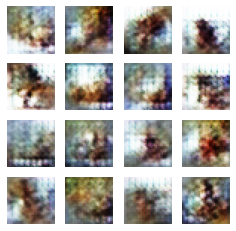

Time for training : 450 sec


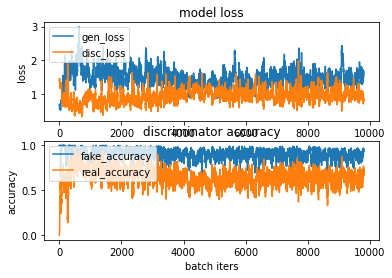

CPU times: user 7min 33s, sys: 15.1 s, total: 7min 48s
Wall time: 7min 31s


In [ ]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/EX.14/EX01_fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/EX.14/generated_samples/EX01_epoch*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/AIFFEL/data/fashion/EX01_fashion_mnist_dcgan.gif

ls: cannot access '/content/drive/MyDrive/AIFFEL/data/fashion/EX01_fashion_mnist_dcgan.gif': No such file or directory


In [ ]:
anim_file = '/content/drive/MyDrive/EX.14/EX01_fashion_loss_accuracy.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/EX.14/training_history/EX01_train_history*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/EX.14/EX01_fashion_loss_accuracy.gif

-rw------- 1 root root 1909054 Jun 23 08:53 /content/drive/MyDrive/EX.14/EX01_fashion_loss_accuracy.gif


## **STEP 8.GAN 훈련 과정 개선하기**

In [ ]:
def make_generator_model_two():

  model = tf.keras.Sequential()
  
  model.add(layers.Dense(8 * 8 * 128, activation='relu', input_shape=(100,)))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Reshape((8, 8, 128)))

  model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Conv2D(128, kernel_size=5, strides=1,padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))
                      
  model.add(layers.Conv2D(3, kernel_size=5, strides=1, padding="same", activation='tanh'))
  
  return model

In [ ]:
generator_two = make_generator_model_two()

generator_two.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization_9 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                     

In [ ]:
# 노이즈를 생성합니다.
noise = tf.random.normal([10, 100])
generated_image = generator_two(noise, training=False)
generated_image.shape

TensorShape([10, 32, 32, 3])

In [ ]:
def make_discriminator_model_two():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=(32, 32, 3), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator_two = make_discriminator_model_two()

discriminator_two.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_15 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                      

In [ ]:
save_every = 5
EPOCHS = 500

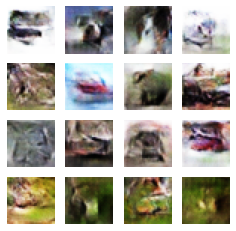

Time for training : 5024 sec


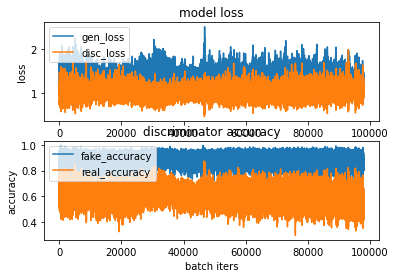

CPU times: user 1h 25min 1s, sys: 2min 17s, total: 1h 27min 18s
Wall time: 1h 23min 47s


In [ ]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [ ]:
def make_generator_model_three():

  model = tf.keras.Sequential()
  
  # first: Dense layer
  model.add(layers.Dense(8 * 8 * 128, activation='relu', input_shape=(100,)))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))
  
  # second: Reshape layer
  model.add(layers.Reshape((8, 8, 128)))

  # third: Conv2D layer
  model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # fourth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # fifth: Conv2D layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1,padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # sixth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # seventh: Conv2D layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # eigth: Conv2D layer                   
  model.add(layers.Conv2D(3, kernel_size=5, strides=1, padding="same", activation='tanh'))
  
  return model

In [ ]:
generator_four = make_generator_model_three()

generator_four.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization_18 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 128)         262272    
                                                                 
 batch_normalization_19 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                     

In [ ]:
# 노이즈를 생성합니다.
noise = tf.random.normal([1, 100])
generated_image = generator_four(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
def make_discriminator_model_three():
    
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=[32, 32, 3]))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(512, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [ ]:
discriminator_four = make_discriminator_model_three()

discriminator_four.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 128)       73856     
                                                      

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.5)

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 16

In [ ]:
save_every = 5
EPOCHS = 400

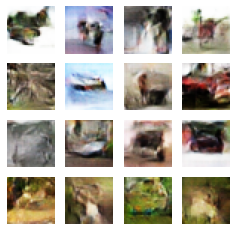

Time for training : 3886 sec


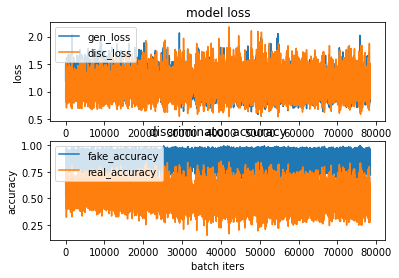

CPU times: user 1h 7min 4s, sys: 1min 11s, total: 1h 8min 15s
Wall time: 1h 4min 50s


In [ ]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

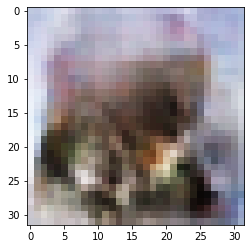

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/EX.14/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

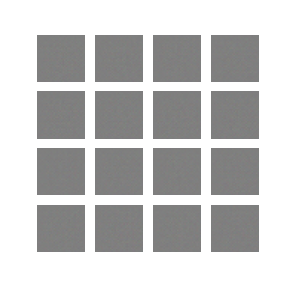

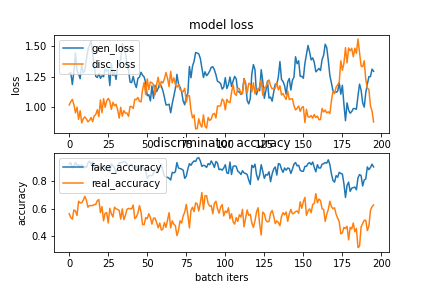

## 회고

참으로 징그러운 결과물이 아닐 수 없습니다.  
어째서 이게 패션인지... 이해가 가지 않습니다..  
인공지능.. 대체 어떤 길을 걷고 계신 겁니까..?  


1. 우선 몇가지 실험을 해보고싶었습니다.  
층을 많이 쌓아서 에포크를 돌렸다면 아마 지금 보다 훨씬 더 좋은 결과를 낼 수 있었을 것 같습니다.  

2. 드롭 아웃을 이용하여 익스를 진행하였는데 최근 공부했던 그롭 커넥트를 적용해 보고 싶었습니다.  
하지만 텐서 플로우 케라스 모델에서 모듈이 없다는 오류가 나와서 결국 제출 시간 때문에 어쩔 수 없아 드롭 아웃으로 진행했습니다.  

3. 제 생각에서 이론상 테이터 확장을 통해 데이터의 수를 많이 늘리고 층을 많이 쌓은 뒤 드롭 아웃이 아닌 드롭 커넥트로 일반화를 시켰다면 더 좋은 결과가 나왔을 거라 생각합니다.  
왜내하면 드롭 아웃을 이용하면 중간층에 있는 몇개의 노드를 비활성화 시키지만 드롭 커넥트를 이용하면 출력에서 중간층으로 넘어가는 선 몇개를 비활성화 합니다.  
그렇다면 데이터 확장을 통해 입력데이터의 수를 늘리고 중간층의 수를 늘린뒤 몇개의 선을 비활성화 했다면 훨씬 더 많은 부분을 지나기 때문에 오류가 줄어 들것 이라는 생각이 듭니다.